In [ ]:
import os
os.chdir('/data3.5T/S312112030/DeepTTA')

print(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.Metrics import MetricsCalculator

ModuleNotFoundError: No module named 'torch'

In [ ]:
tcga_df = pd.read_csv("../data/TCGA/TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt", sep='\t', index_col=0)
ccle_df = pd.read_csv("../data/CCLE/CCLE_exp_476samples_4692genes.txt", sep='\t', index_col=0)

In [ ]:
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)

In [ ]:
get_data_value_range(tcga_df,"TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt")
get_data_value_range(ccle_df,"CCLE_exp_476samples_4692genes.txt")
get_data_value_range(AUC_df,"Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv")

In [ ]:
AUC_dropNAN=AUC_df.values.ravel()
AUC_dropNAN = AUC_dropNAN[~np.isnan(AUC_dropNAN)]
print(len(AUC_dropNAN))

In [ ]:
AUC_dropNAN_log2= np.log2(AUC_dropNAN+1) # np.log2(AUC_dropNAN+1)
# epsilon = 1e-6  # Small constant to handle zeros
# AUC_dropNAN_log2 = np.log(AUC_dropNAN_log2 + epsilon)

In [1]:
get_data_value_range(AUC_dropNAN_log2,"log(-log2) Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv")

NameError: name 'get_data_value_range' is not defined

In [ ]:
plt.figure(figsize=(8, 6))

# Prepare data for boxplot
data = [tcga_df.values.ravel(), ccle_df.values.ravel()]
labels = ['TCGA', 'CCLE']
        
sns.boxplot(data=data, palette=['blue', 'red'], linewidth=1.5)
plt.xticks(ticks=[0, 1], labels=labels, fontsize=12)
plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Expression Values', fontsize=16)
plt.title('Boxplot of Expression Values', fontsize=16)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example data
np.random.seed(42)
tcga_data = tcga_df.values.ravel()
ccle_data = ccle_df.values.ravel()

# Prepare DataFrame
data = pd.DataFrame({
    'Value': np.concatenate([tcga_data[:20], ccle_data[:20]]),
    'Dataset': ['TCGA'] * len(tcga_data[:20]) + ['CCLE'] * len(ccle_data[:20])
})

# Create the plot
plt.figure(figsize=(6, 8))
sns.violinplot(data=data, x='Dataset', y='Value', hue='Dataset', palette=['#62bcf0','#f76868' ], split=True,gap=0.5, inner=None, linewidth=1.5,legend=False)
sns.boxplot(data=data, x='Dataset', y='Value', hue='Dataset', width=0.2, palette=['blue','red'], showfliers=True,legend=False)
# sns.stripplot(data=data, x='Dataset', y='Value', jitter=True, palette=['#f76868', '#62bcf0'], alpha=0.5)


# Customize labels and legend
plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Expression Values', fontsize=16)
plt.title('Combined Boxplot, Density, and Dot Plot', fontsize=16)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tcga_data = tcga_df.values.ravel()
ccle_data = ccle_df.values.ravel()
data = pd.DataFrame({
    'Value': np.concatenate([tcga_data, ccle_data]),
    'Dataset': ['TCGA'] * len(tcga_data) + ['CCLE'] * len(ccle_data)
})

df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(7, 5))
sns.violinplot(x='Dataset', y='Value', data=df, inner=None, linewidth=2,split=True,gap=0.2,cut=0,
    palette={'TCGA': 'skyblue', 'CCLE': 'salmon'})
flierprops = dict(marker='o', markersize=4, markeredgewidth=1, markerfacecolor='none')
meanprops={"marker": "*", "markersize":5, "markerfacecolor": "#faa507", "markeredgecolor": "#faa507", "markeredgewidth": 0.5}
sns.boxplot(x='Dataset', y='Value', data=df, width=0.3, showmeans=True,meanprops=meanprops,
    boxprops={'facecolor': 'none','linewidth': 1.2, 'edgecolor': 'k'}, showfliers=True,flierprops=flierprops,whiskerprops={'linewidth': 1.5, 'color': 'k'})

# # Add significance marker
#plt.text(0.5, 0.28, '*', fontsize=20, ha='center', va='bottom')

# Customize the plot
plt.ylabel('Expression Value', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Dataset', fontsize=15)
plt.title('Violin-Boxplot of Expression Values', fontsize=15)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# Create a DataFrame with a single condition
data = {
    'Sample': [f'Sample{i+1}' for i in range(len(AUC_dropNAN_log2))],
    'Expression_Level': AUC_dropNAN_log2,
    'Condition': [' '] * len(AUC_dropNAN_log2)  # Single condition for all samples
}
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Expression_Level', orient='h', y='Condition', hue='Condition', legend=False,split=True,gap =0.6, data=df, inner=None, palette=['#62bcf0'], cut=0, linewidth=1,edgecolor='#0292e6')
flierprops = dict(marker='o', markersize=5, markeredgewidth=1, markerfacecolor='skyblue')
meanprops={"marker": "*", "markersize":5, "markerfacecolor": "#faa507", "markeredgecolor": "#faa507", "markeredgewidth": 0.5}
sns.boxplot(x='Expression_Level', orient='h', y='Condition', data=df, width=0.1, showcaps=True, boxprops={'facecolor': 'none', 'edgecolor': 'k'}, 
     showfliers=True,flierprops=flierprops,whiskerprops={'linewidth': 1.5, 'color': 'k'}, showmeans=True,meanprops=meanprops)
# sns.stripplot(x='Expression_Level', y='Condition', data=df, color='#b6e1fa', size=0.1, jitter=True)

# Customize the plot
plt.ylabel('Density', fontsize=12)
plt.xlabel('AUC value', fontsize=12)
plt.title('Half Violin and Boxplot for AUC', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
# Assuming AUC_df is already defined
data = {
    'Sample': [f'Sample{i+1}' for i in range(len(AUC_dropNAN_log2))],
    'AUC_values': AUC_dropNAN_log2,
    'Condition': [' '] * len(AUC_dropNAN_log2)  # Single condition for all samples
}
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(7, 5))

# Replace violin plot with a density plot (KDE plot)
sns.kdeplot( AUC_dropNAN_log2, fill=True, palette="#62bcf0", linewidth=2,cut=0)

# Add the boxplot
# Set the properties for the outlier dots in the boxplot
flierprops = dict(marker='o', markersize=5, markeredgewidth=1, markerfacecolor='skyblue')
sns.boxplot(AUC_dropNAN_log2, 
            orient='h', 
            width=0.6, 
            showcaps=True, 
            boxprops={'facecolor': 'none','linewidth': 2, 'edgecolor': 'k'}, 
            medianprops={'linewidth': 2, 'color': 'k'},                  
            showfliers=True, 
            flierprops=flierprops, 
            whiskerprops={'linewidth': 1.5, 'color': 'k'}, 
            showmeans=True,
            meanline=True,
            capprops={'linewidth': 2, 'color': 'k'},
            meanprops={"linestyle":'-', "linewidth":2, "color":'#d48b04'}  # Blue mean line similar to Q2
            )
# 計算 Q1, Q3 和 IQR
Q1 = np.percentile(df['AUC_values'], 25)
Q3 = np.percentile(df['AUC_values'], 75)
IQR = Q3 - Q1
threshold = Q1 - 1.5 * IQR # Q3 + 1.5 * IQR # Q1- 1.5 * IQR 

# Calculate data counts for threshold
auc_greater_than_threshold = df[df['AUC_values'] >= threshold].shape[0]
auc_less_than_threshold = df[df['AUC_values'] < threshold].shape[0]
total = auc_greater_than_threshold + auc_less_than_threshold
# Q3+1.5IQR Q1-1.5IQR 
legend_elements = [
    Line2D([0], [0], color='none', label=f'AUC >= {threshold:.2f}(Q1-1.5IQR) (n={auc_greater_than_threshold}, {(auc_greater_than_threshold / total * 100):.2f}%)'),
    Line2D([0], [0], color='none', label=f'AUC < {threshold:.2f}(Q1-1.5IQR) (n={auc_less_than_threshold}, {(auc_less_than_threshold / total * 100):.2f}%)'),
    Line2D([0], [0], color='#d48b04', lw=2, linestyle='solid', label='Mean'),
    Line2D([0], [0], marker='o', markersize=5, markeredgewidth=1, markerfacecolor='skyblue', label='Outliers', linestyle='None'),
  ]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Customize the plot
plt.ylabel('Density', fontsize=15)
plt.xlabel('AUC_values', fontsize=15)
plt.title('Density Plot and Boxplot for AUC', fontsize=15)
plt.tight_layout()
plt.ylim(-1, 5.5) #
plt.yticks(range(0, 5),[str(y) for y in range(0, 5)]) # Ensure ticks are shown
# Show the plot
plt.show()

In [ ]:
sns.kdeplot( AUC_dropNAN_log2, fill=True, palette="#62bcf0", linewidth=2,cut=0, label='log2(AUC+1)')
sns.kdeplot( AUC_dropNAN, fill=True, palette="#62bc50", linewidth=2,cut=0, label='AUC')
plt.legend(loc='upper left', fontsize=13)
plt.xlabel('AUC Value', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

In [ ]:

auc_values = AUC_dropNAN_log2

# 將 AUC 值分組，每組間隔 0.05
bins = np.arange(0, 1.02, 0.05)

categories = pd.cut(auc_values, bins, right=True) #right=True(]; right=False[)

# Calculate the count for each bin
bin_counts = categories.value_counts().sort_index()

# Print the count of each interval
print(bin_counts)

# 計算每個區間的數量
df = pd.DataFrame({'AUC_range': categories})
df['count'] = df.groupby('AUC_range').size()


# 使用 Seaborn繪製條形圖
sns.countplot(x='AUC_range', data=df)
plt.xticks(rotation=45)
plt.xlabel('-log AUC Range')
plt.ylabel('Count')

plt.title('Distribution of -log10 AUC Values')
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
np.random.seed(42)
# Generate a right-skewed array using an exponential distribution
right_skewed_array = np.random.exponential(scale=2.0, size=1000)

# Calculate the skewness
calculated_skewness = skew(right_skewed_array)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.histplot(right_skewed_array, kde=True, color='skyblue', bins=30)
plt.title(f"Right-Skewed Distribution (Skewness: {calculated_skewness:.2f})", fontsize=15)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

right_skewed_array[:10], calculated_skewness

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.Metrics import MetricsCalculator

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [2]:
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalMSELoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset

omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DrugESPF_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 5
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = True
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 200
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-04
#criterion = Custom_LossFunction(loss_type="MSE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
criterion =  FocalMSELoss(alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)



In [3]:

set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed  
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

Exp tensor shape: torch.Size([476, 4692])
Exp num_features 4692


In [4]:
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# matched AUCfile and omics_data samples
matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))

AUC_df= (AUC_df.T[matched_samples]).T

print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

AUC_df (476, 1440)
drug_df (1440, 9)
AUC_df (476, 1440)


In [5]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)


if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
    # print("weighted_threshold",weighted_threshold)
    # print("total_samples",total_samples)
    # print("few_samples",few_samples)
    # print("more_samples",more_samples)
    # print("few_weight",few_weight)
    # print("more_weight",more_weight)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [6]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)

num_ccl,num_drug:  476 1440
torch.Size([476, 1440])


In [7]:
if kfoldCV>1:
    id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
    # repeat the test id
    if splitType == "byCCL":
        repeatNum = num_drug
    elif splitType == "byDrug":
        repeatNum = num_ccl
    id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (380,)
id_unrepeat_val (48,)
id_unrepeat_test (48,)
id_unrepeat_train_val (428,)
id_test.shape (69120,)


In [8]:
print(id_test[:10])

[10080 10081 10082 10083 10084 10085 10086 10087 10088 10089]


In [ ]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , num_workers=4, pin_memory=True
#create whole dataset
whole_loader = DataLoader(dataset, batch_size=2000, shuffle=False) # 685440


In [ ]:
%%time
# Evaluation
val_epoch_loss_list=None
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
best_weight_path = './inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

model_outputs = evaluation(model, val_epoch_loss_list, criterion, whole_loader, device,ESPF,Drug_SelfAttention, weighted_threshold, few_weight, more_weight, outputcontrol='inference')
# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
eval_targets, eval_outputs,predAUCwithUnknownGT,_ ,_,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty = model_outputs[0],model_outputs[1],model_outputs[2],model_outputs[3],model_outputs[4],model_outputs[5],model_outputs[6]


State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
) loaded successfully.

 Drug_SelfAttention is applied 

CPU times: user 29.7 s, sys: 417 ms, total: 30.1 s
Wall time: 32.6 s


In [18]:
predAUCwithUnknownGT_list = np.concatenate(predAUCwithUnknownGT)
print(predAUCwithUnknownGT_list.shape)
predAUCmatrix = predAUCwithUnknownGT_list.reshape(476, 1440) # numpy.ndarray

predAUCmatrix_df = pd.DataFrame(predAUCmatrix, columns=AUC_df.columns, index=AUC_df.index)
# Output to CSV
predAUCmatrix_df.to_csv(best_weight_path+'predicted AUC values with UnknownGroundTruth samples.csv')
print("CSV file has been saved.")

(685440,)


PermissionError: [Errno 13] Permission denied: './inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/predicted AUC values with UnknownGroundTruth samples.csv'

In [19]:
print("test_targets\n",test_targets[0][:10])
print("test_outputs_before_final_activation_list\n",test_outputs_before_final_activation_list[0][:10])
print("test_outputs\n",test_outputs[0][:10])

NameError: name 'test_targets' is not defined

In [20]:
metrics_calculator = MetricsCalculator()
test_metrics= metrics_calculator.compute_all_metrics(np.concatenate(eval_targets), np.concatenate(eval_outputs),set_name='eval_set')
metrics_calculator.print_results(set_name='eval_set')

Evaluation eval_set
{'Evaluation': 'eval_set', 'RMSE': 0.07615192, 'MAE': 0.055474956, 'R^2': 0.7736417502164841}


In [21]:
# if splitType == "byCCL":
#     id_unrepeat_whole = list(range(476))
# elif splitType == "byDrug":
#     id_unrepeat_whole = list(range(1440))
#     id_unrepeat_whole[:10], id_unrepeat_whole[-10:]  # Display the first and last 10 elements to confirm

In [22]:
# Correlation
whole_index = list(range(476))
eval_pearson, eval_spearman,eval_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,whole_index,eval_targets,eval_outputs)

Text(0.5, 0.98, 'Density Plot of Correlation Omics_DrugESPF_Model')

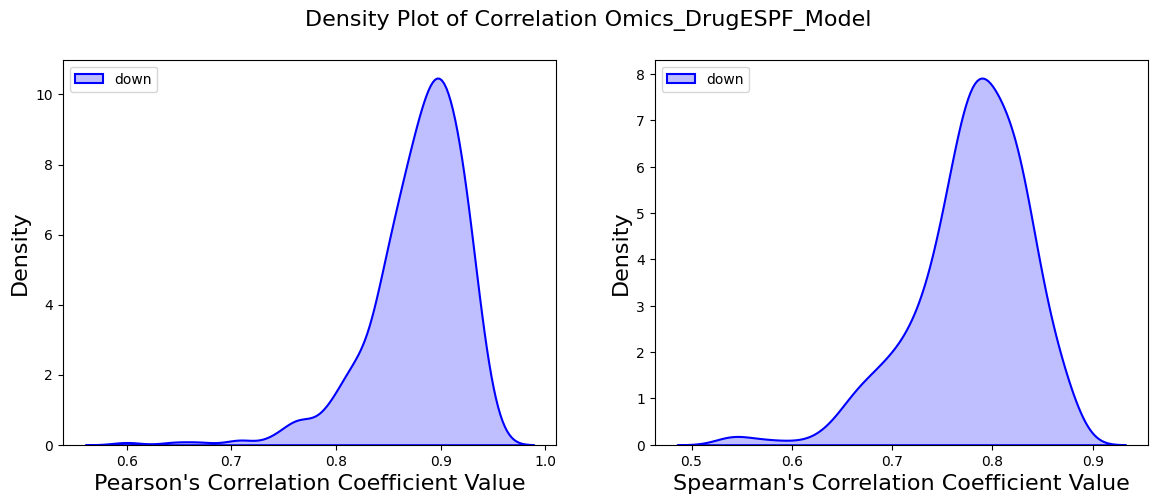

In [23]:
#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot

plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 

plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

In [24]:
# for name, pearson in [("Test", test_pearson1)]:
#     print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
# for name, spearman in [("Test", test_spearman1)]:
#     print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

for name, pearson in [("Test", eval_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", eval_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")


Mean Median Mode Test Pearson Omics_DrugESPF_Model:	0.877792 ± 0.0454	-1.693300	 0.886623	ModeResult(mode=0.9, count=64)

Mean Median Mode Test Spearman Omics_DrugESPF_Model:	0.778543 ± 0.0564	-1.056978	 0.785663	ModeResult(mode=0.77, count=43)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

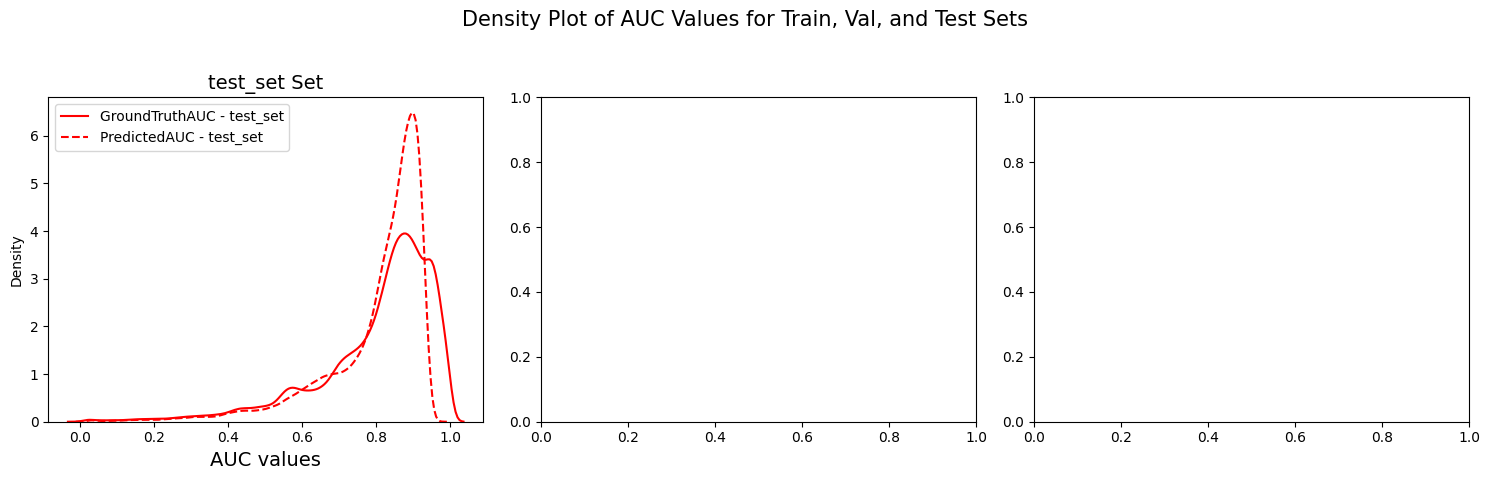

In [25]:
datas = [(eval_targets, eval_outputs, 'test_set', 'red')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

In [13]:
predAUCmatrix_df = pd.read_csv("./inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [11]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == "Bowel"].tolist()
print(type_indices)
# print(predAUCmatrix_df.loc[type_indices])

(480, 1)
(476, 1)
['ACH-000007', 'ACH-000252', 'ACH-000296', 'ACH-000403', 'ACH-000421', 'ACH-000467', 'ACH-000532', 'ACH-000552', 'ACH-000565', 'ACH-000651', 'ACH-000680', 'ACH-000842', 'ACH-000895', 'ACH-000926', 'ACH-000943', 'ACH-000950', 'ACH-000955', 'ACH-000957', 'ACH-000958', 'ACH-000959', 'ACH-000967', 'ACH-000970', 'ACH-000971', 'ACH-000982', 'ACH-000985', 'ACH-000991', 'ACH-000997']


In [14]:
# get GT AUC of specific drug and type of ccl
GT_AUC_df_Bowel_5flu = (AUC_df.loc[type_indices])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']]
print(np.concatenate(GT_AUC_df_Bowel_5flu.values).shape)

# get predicted AUC of sepecific drug and type of ccl
predAUCmatrix_df_Bowel_5flu = (predAUCmatrix_df.loc[type_indices])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']]
print(np.concatenate(predAUCmatrix_df_Bowel_5flu.values).shape)

(27,)
(27,)


In [23]:
# get specific mut gene label 0/1
include_omics = ['Mut']
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    omics_data_dict[omic_type] = omics_data_dict[omic_type].loc[type_indices] #  index of specific CCL type's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]).shape ) 
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])['TP53'] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    

(27, 6009)
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]


In [24]:
#get mask from GT_AUC_df_Bowel_5flu and get GT_AUC_df_Bowel_5flu_dropnan
mask = ~np.isnan(np.concatenate(GT_AUC_df_Bowel_5flu.values))
GT_AUC_df_Bowel_5flu_dropnan = GT_AUC_df_Bowel_5flu.dropna()
GT_AUC_df_Bowel_5flu_dropnan.shape

(15, 1)

In [25]:
# get mutation label after mask for GT boxplot
GT_mut_label_masked=np.array(sample_mut_label)[mask]
print("GT_mut_label_masked",GT_mut_label_masked)
# turn 0/1 to 'w/0 TP53_Mut'/'TP53_Mut'
GT_mut_label_masked = ['TP53_Mut' if label == 1 else 'w/0 TP53_Mut' for label in GT_mut_label_masked]
print(len(GT_mut_label_masked))
sample_mut_label = ['TP53_Mut' if label == 1 else 'w/0 TP53_Mut' for label in sample_mut_label]
print("sample_mut_label/n",sample_mut_label)

GT_mut_label_masked [0 1 1 1 1 1 0 0 0 1 1 0 0 1 1]
15
sample_mut_label/n ['w/0 TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/0 TP53_Mut', 'w/0 TP53_Mut', 'TP53_Mut', 'w/0 TP53_Mut', 'w/0 TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/0 TP53_Mut', 'w/0 TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut']


7
20


/tmp/ipykernel_3040/2524763574.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
/tmp/ipykernel_3040/2524763574.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)


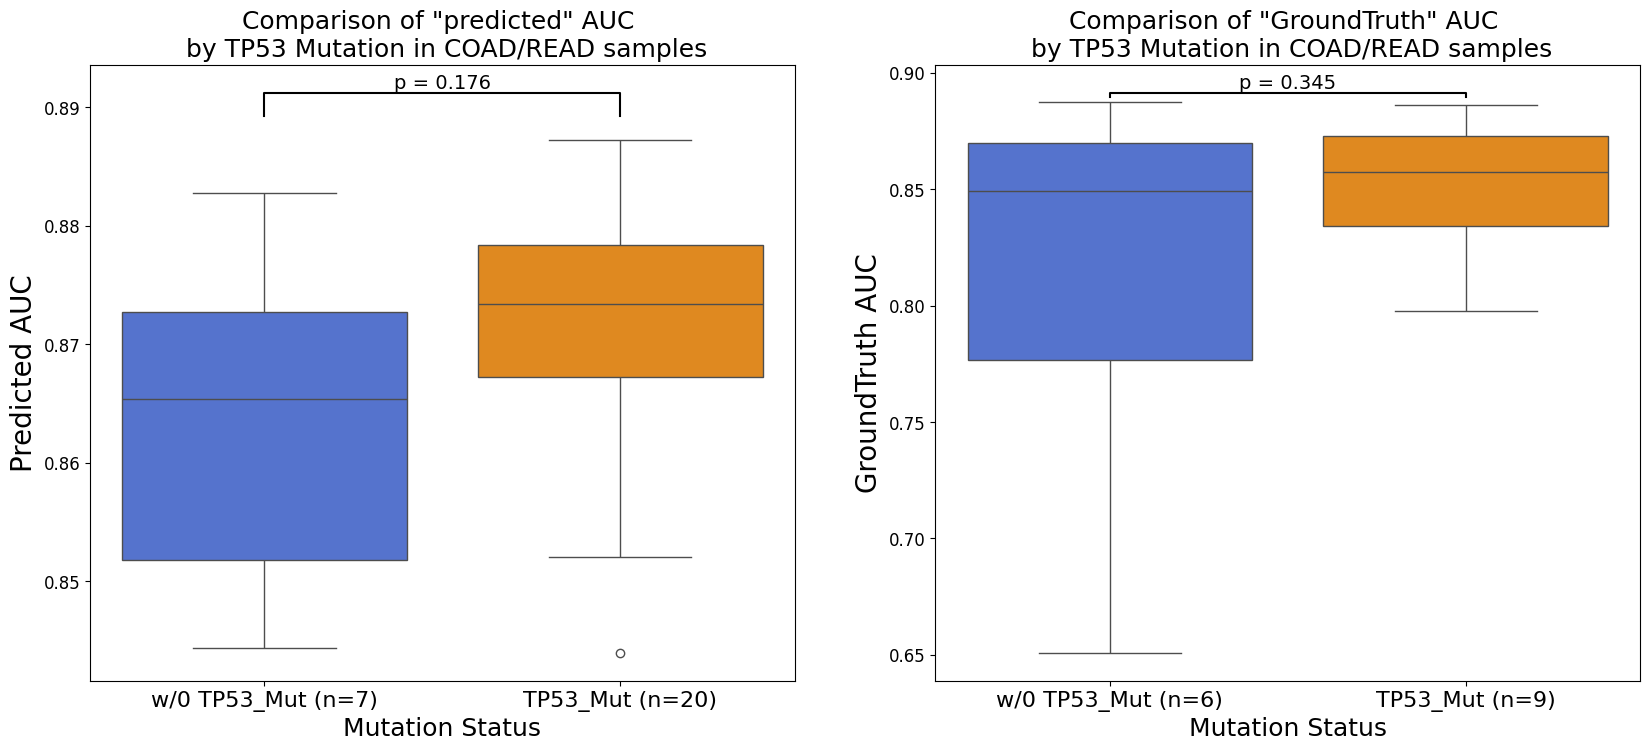

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'predicted AUC': np.concatenate(predAUCmatrix_df_Bowel_5flu.values) , 'mutation_status': sample_mut_label})
# Perform t-test
group1 = df[df["mutation_status"] == "w/0 TP53_Mut"]["predicted AUC"]
group2 = df[df["mutation_status"] == "TP53_Mut"]["predicted AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {"w/0 TP53_Mut": "royalblue", "TP53_Mut": "darkorange"}
fig=plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = df["predicted AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([0, 1], [f'w/0 TP53_Mut (n={len(group1)})', f'TP53_Mut (n={len(group2)})'], fontsize=16)
plt.title('Comparison of "predicted" AUC \n by TP53 Mutation in COAD/READ samples',fontsize=18)
plt.xlabel('Mutation Status', fontsize=18)
plt.ylabel('Predicted AUC', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.subplot(1,2,2)
GTdf = pd.DataFrame({'GroundTruth AUC': np.concatenate(GT_AUC_df_Bowel_5flu_dropnan.values) , 'mutation_status': GT_mut_label_masked})
group1 = GTdf[GTdf["mutation_status"] == "w/0 TP53_Mut"]["GroundTruth AUC"]
group2 = GTdf[GTdf["mutation_status"] == "TP53_Mut"]["GroundTruth AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {"w/0 TP53_Mut": "royalblue", "TP53_Mut": "darkorange"}
ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = GTdf["GroundTruth AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([0, 1], [f'w/0 TP53_Mut (n={len(group1)})', f'TP53_Mut (n={len(group2)})'], fontsize=16)
plt.xlabel('Mutation Status', fontsize=18)
plt.ylabel('GroundTruth AUC', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.title('Comparison of "GroundTruth" AUC \n by TP53 Mutation in COAD/READ samples',fontsize=18)
plt.show()

## Attention Score Matrix

In [6]:
predAUCmatrix_df = pd.read_csv("./inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [7]:
# get specific drug and ccl
drug_df= drug_df[drug_df['name'] == "5-fluorouracil"]
print(drug_df)
print("\n")
#get pair GT response 
GT_AUC_df_pair = (AUC_df.loc['ACH-000007'])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("GT_AUC_df_pair\n",GT_AUC_df_pair)
#get pair predicted response 
predAUCmatrix_df_pair = (predAUCmatrix_df.loc['ACH-000007'])[['FLUOROURACIL (BRD:BRD-K24844714-001-24-5)']]
print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

                              BRD_ID            name  \
Name                                                   
FLUOROURACIL  BRD-K24844714-001-24-5  5-fluorouracil   

                                         moa      target disease.area  \
Name                                                                    
FLUOROURACIL  thymidylate synthase inhibitor  DPYD, TYMS     oncology   

                                                     indication     phase  \
Name                                                                        
FLUOROURACIL  colorectal cancer, breast cancer, pancreatic c...  Launched   

                             smiles  \
Name                                  
FLUOROURACIL  Fc1c[nH]c(=O)[nH]c1=O   

                                                   MACCS166bits  
Name                                                             
FLUOROURACIL  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  


GT_AUC_df_pair
 FLUOROURACIL (BRD:BRD-K24844714-001-24-5)    

In [8]:
include_omics = ['Exp']
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    print((omics_data_dict[omic_type]).shape )
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])['TP53'] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    
    omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc["ACH-000007"]).to_numpy().reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]).shape )

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    

(476, 4692)
(1, 4692)
Exp tensor shape: torch.Size([1, 4692])
Exp num_features 4692


In [9]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # drug_encode = pd.Series(drug_smiles.unique()).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))# 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    # uniq_smile_dict = dict(zip(drug_smiles.unique(),drug_encode))# zip drug_smiles和其subword vector編碼 成字典

    # print(type(smile_encode))
    # print(smile_encode.shape)
    # print(type(smile_encode.index))
    # print((drug_encode.index.values).shape)#(42,)
    # print((drug_encode).shape)#(42,)
    # print(type(drug_encode))#<class 'pandas.core.series.Series'>
    #print((drug_encode.values).shape)#(42,)
    # print(drug_encode.values.tolist())
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
print(omics_data_tensor_dict)
print(drug_features_tensor.shape)
print(response_matrix_tensor.shape)

num_ccl,num_drug:  1 1
{'Exp': tensor([[0.0200, 0.0183, 0.0000,  ..., 0.5090, 0.0044, 0.6082]],
       device='cuda:0')}
torch.Size([1, 2, 50])
torch.Size([1, 1])


In [10]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [11]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [20]:
%%time
# Evaluation
val_epoch_loss_list=None
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
best_weight_path = './inference/BestFold2_test_loss0.0044098_BestValEpo8_ModelOmics_DrugESPF_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

model_outputs = evaluation(model, val_epoch_loss_list, criterion, one_loader, device,ESPF,Drug_SelfAttention, weighted_threshold, few_weight, more_weight, outputcontrol='inference')
# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,_, _ = model_outputs[0],model_outputs[1],model_outputs[2],model_outputs[3],model_outputs[4],model_outputs[5],model_outputs[6]


State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
) loaded successfully.

 Drug_SelfAttention is applied 

CPU times: user 437 ms, sys: 42.7 ms, total: 479 ms
Wall time: 2.6 s


In [ ]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

torch.Size([1, 8, 50, 50])
torch.Size([50, 50])


In [29]:
from scipy.stats import pearsonr, spearmanr

In [54]:
GT=np.array([2,3,4,5,6])

Pred1=np.array([5,4,3,2,1])
Pred2=np.array([1,2,3,4,5])

mseloss=(((Pred1-GT)**2).sum())/5
print("mseloss",mseloss)
correlation_coef, p_value = pearsonr(Pred1, GT)
print("correlation_coef",correlation_coef)
correlation_coef=abs(correlation_coef)
print("correlation_coef",correlation_coef)
spearman_correlation_coef1, p_value = spearmanr(Pred1, GT)
print("spearman_correlation_coef",spearman_correlation_coef1)

mseloss=(((Pred2-GT)**2).sum())/5
print("mseloss",mseloss)
correlation_coef, p_value = pearsonr(Pred2, GT)
correlation_coef=abs(correlation_coef)
print("correlation_coef",correlation_coef)
spearman_correlation_coef2, p_value = spearmanr(Pred2, GT)
print("spearman_correlation_coef",spearman_correlation_coef2)



mseloss 9.0
correlation_coef -1.0
correlation_coef 1.0
spearman_correlation_coef -0.9999999999999999
mseloss 1.0
correlation_coef 1.0
spearman_correlation_coef 0.9999999999999999


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


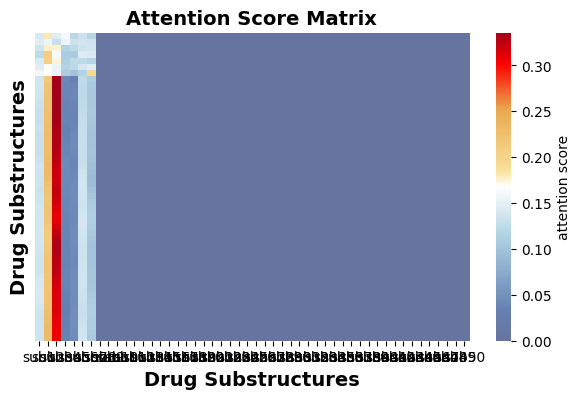

In [27]:
heatmap(AttenScorMat_DrugSelf.cpu(),"AttenScorMat_DrugSelf" )

In [25]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]

# Remove columns with all zeros
non_zero_tensor = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]

print(non_zero_tensor)
print(non_zero_tensor.shape)

tensor([[0.1410, 0.1809, 0.1461, 0.1604, 0.1196, 0.1334, 0.1186],
        [0.1480, 0.1572, 0.1322, 0.1559, 0.1334, 0.1386, 0.1346],
        [0.1352, 0.1759, 0.1752, 0.1157, 0.1255, 0.1349, 0.1378],
        [0.1249, 0.2059, 0.1622, 0.1097, 0.1085, 0.1457, 0.1431],
        [0.1433, 0.2041, 0.1737, 0.1117, 0.1237, 0.1243, 0.1192],
        [0.1472, 0.1699, 0.1568, 0.1166, 0.1221, 0.1396, 0.1478],
        [0.1599, 0.1672, 0.1543, 0.1097, 0.1014, 0.1163, 0.1911],
        [0.1383, 0.2138, 0.3335, 0.0412, 0.0365, 0.1258, 0.1107],
        [0.1379, 0.2165, 0.3347, 0.0406, 0.0385, 0.1244, 0.1075],
        [0.1366, 0.2196, 0.3352, 0.0396, 0.0404, 0.1235, 0.1052],
        [0.1349, 0.2217, 0.3352, 0.0386, 0.0410, 0.1237, 0.1049],
        [0.1331, 0.2227, 0.3354, 0.0378, 0.0400, 0.1249, 0.1060],
        [0.1320, 0.2231, 0.3357, 0.0374, 0.0386, 0.1264, 0.1069],
        [0.1318, 0.2237, 0.3352, 0.0371, 0.0380, 0.1279, 0.1063],
        [0.1324, 0.2249, 0.3336, 0.0368, 0.0388, 0.1293, 0.1043],
        [0

In [43]:
non_zero_tensor.shape

torch.Size([50, 7])

In [49]:
(non_zero_tensor.cpu()).shape[1]

7

In [45]:
drug_features_tensor

tensor([[[ 49, 616,  26,  63, 118,  70, 180,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0],
         [  1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]], device='cuda:0')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


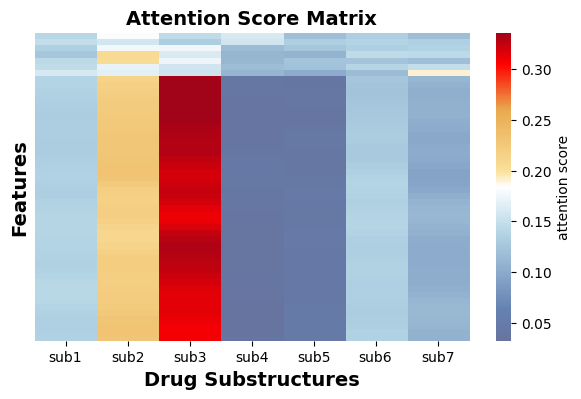

In [53]:
heatmap(non_zero_tensor.cpu() )

In [26]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
def heatmap(attention_scores,module=""):
    # Define the colors and their corresponding positions (anchors)
    colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)

    # Create a custom colormap with specified anchors
    custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    plt.figure(figsize=(7, 4))

    plt.imshow(attention_scores, aspect="auto", cmap=custom_cmap)
    cbar = plt.colorbar(label="attention score")
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    plt.title("Attention Score Matrix", fontsize=14, fontweight='bold')

    # Set x and y axis labels
    plt.xlabel("Drug Substructures", fontsize=14, fontweight='bold', fontname='Times New Roman')
    if module == "AttenScorMat_DrugSelf":
        plt.ylabel("Drug Substructures", fontsize=14, fontweight='bold', fontname='Times New Roman')
    if module == "AttenScorMat_DrugCellSelf":
        plt.ylabel("Features", fontsize=14, fontweight='bold', fontname='Times New Roman')

    # Optionally, set the x and y ticks (example with some labels)
    plt.xticks(ticks=np.arange(0, attention_scores.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores.shape[1])])
    # if module == "AttenScorMat_DrugSelf":
    #     plt.yticks(ticks=np.arange(0, attention_scores.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores.shape[1])])
    # if module == "AttenScorMat_DrugCellSelf":
    #     plt.yticks(ticks=np.arange(0, attention_scores.shape[0], step=1), labels=[f"Feature {i+1}" for i in range(attention_scores.shape[0])])
    plt.yticks([])
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()